# 305.2. Stellar Variability Characterization

<div style="max-width:300px; float: left; margin-right: 1em">

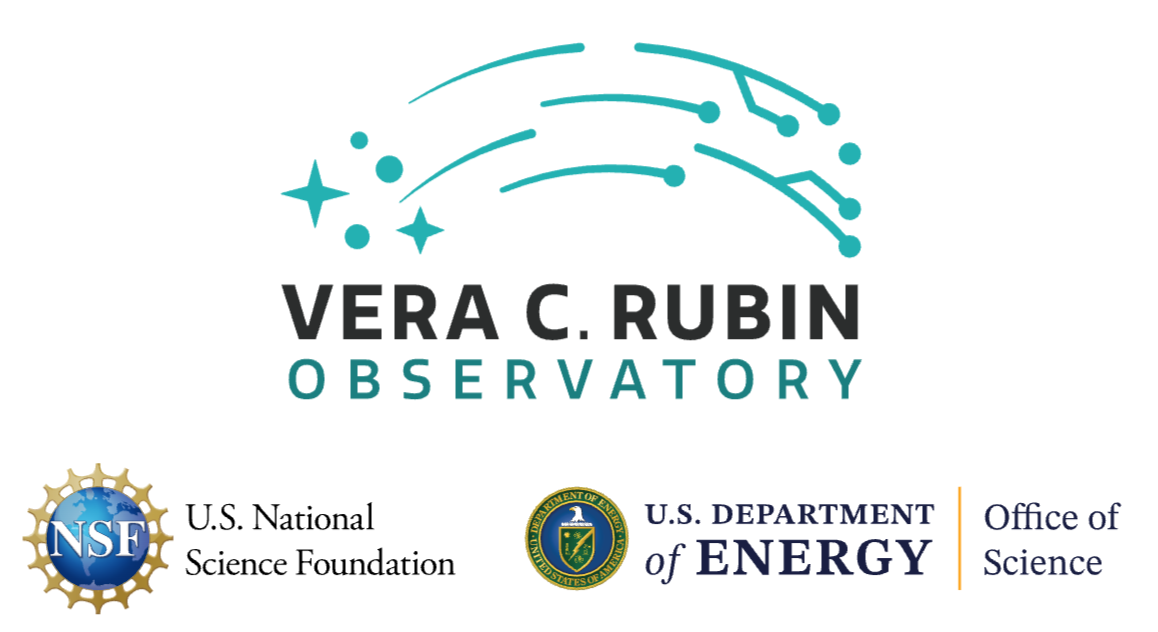

</div>

For the Rubin Science Platform at data.lsst.cloud. <br>
Data Release: <a href="https://dp1.lsst.io/">Data Preview 1</a> <br>
Container Size: large <br>
LSST Science Pipelines version: Release r29.2.0 <br>
Last verified to run: 2026-01-29 <br>
Repository: <a href="https://github.com/lsst/tutorial-notebooks">github.com/lsst/tutorial-notebooks</a> <br>
DOI: [10.11578/rubin/dc.20250909.20](https://doi.org/10.11578/rubin/dc.20250909.20)

**Learning objective:** Learn a way of identifying candidate variable stars in DP1.

**LSST data products:** `DiaObject`, `ForcedSourceOnDiaObject`, `CcdVisit`

**Packages:** `matplotlib`, `numpy`, `Astropy`, `astroquery`, `lsst.rsp`, `lsst.utils.plotting`

**Credit:**
Originally developed by the Rubin Community Science team.
Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:**
Everyone is encouraged to ask questions or raise issues in the 
<a href="https://community.lsst.org/c/support">Support Category</a> 
of the Rubin Community Forum.
Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook demonstrates how to use the lightcurve statistics in the DiaObject table to identify candidate variable stars. The candidates are then run through a Lomb-Scargle periodogram finder to identify likely periodicity, after which phased lightcurves are plotted.

Related tutorials: There are 200-level tutorials on `difference_images` as well as the `DiaSource`, `DiaObject` and `ForcedSourceOnDiaObject` catalogs. There is another notebook in this 305 series (305.1) that presents how to make a light curve of a known variable star. The 207-level tutorials explain timeseries quantities that are available in the `DiaObject` table.


### 1.1. Import packages

Import `numpy`, a fundamental package for scientific computing with arrays in Python
(<a href="https://numpy.org">numpy.org</a>), and
`matplotlib`, a comprehensive library for data visualization
(<a href="https://matplotlib.org/">matplotlib.org</a>; 
<a href="https://matplotlib.org/stable/gallery/index.html">matplotlib gallery</a>).
From `Astropy` (<a href="https://www.astropy.org/">astropy.org</a>) import the units and SkyCoord modules and the Lomb-Scargle periodogram tools.

From the `lsst` package, import modules for accessing the Table Access Protocol (TAP) service, and plotting functions from the LSST Science Pipelines (<a href="https://pipelines.lsst.io/">pipelines.lsst.io</a>).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import vstack
from astropy.timeseries import LombScargle, LombScargleMultiband

from lsst.rsp import get_tap_service
from lsst.utils.plotting import (get_multiband_plot_colors,
                                 get_multiband_plot_symbols)

### 1.2. Define parameters and functions

Create an instance of the TAP service, and assert that it exists.

In [2]:
service = get_tap_service("tap")
assert service is not None

Define filter names, plot markers, linestyles, and colors for plotting

In [3]:
filter_names = ['u', 'g', 'r', 'i', 'z', 'y']
filter_colors = get_multiband_plot_colors()
filter_symbols = get_multiband_plot_symbols()

## 2. Find candidate variable stars

The `DiaObject` table contains many lightcurve summary statistics, which are derived from the contents of the `DiaSource` table. See <a href="https://sdm-schemas.lsst.io/dp1.html#DiaObject">the schema for DiaObject</a> for a list of columns. Details of these statistical quantities summarizing the properties of each `DiaObject`'s lightcurve are given in the 207-series tutorials on "Timeseries values" and "Timeseries distributions."

For this tutorial, we want to identify variable stars in our own Milky Way galaxy. It thus makes the most sense to conduct a search in the "Low Galactic Latitude" field from the DP1 dataset (see the 301-series notebook on this field for details about the dataset). Not only will this field have relatively high stellar density, but it is also well sampled, with a total of 292 visits in DP1.

### 2.1. Get a sample of DiaObjects

To identify candidates such as the periodic variable star from the first notebook in the 305-series, we wish to select stars that are varying in brightness significantly. We will do so by using `[f]_psfFluxSigma` and the inter-quartile range (IQR) of the fluxes derived from the percentiles `[f]_psfFluxPercentile25` and `[f]_psfFluxPercentile75`. We will also use `r_psfFluxStetsonJ`, which reports the Stetson J-index, an indicator of periodic variability.

For this tutorial, we will focus on the *r*-band measurements. Note that the statistics selected below are all based on the difference-image point source flux values, except for `r_scienceFlux*`, which are based on the calibrated `visit_image`.

Query the `DiaObject` table in a 1-degree radius about the center of the low-latitude field, extracting stars with direct-image signal-to-noise (S/N) greater than 5, and with at least 40 `DiaSource` measurements:

In [4]:
ra = 95.0
dec = -25.0

In [5]:
query = "SELECT ra, dec, diaObjectId, "\
        "r_psfFluxMean, nDiaSources, r_scienceFluxMean, r_scienceFluxMeanErr, "\
        "r_psfFluxNdata, r_psfFluxSigma, r_psfFluxMAD, r_psfFluxChi2, "\
        "r_psfFluxStetsonJ, r_psfFluxPercentile25, r_psfFluxPercentile75, "\
        "scisql_nanojanskyToAbMag(r_scienceFluxMean) as rmag, "\
        "scisql_nanojanskyToAbMag(g_scienceFluxMean) as gmag "\
        "FROM dp1.DiaObject "\
        "WHERE CONTAINS (POINT('ICRS', ra, dec), "\
        "CIRCLE('ICRS'," + str(ra) + ", " + str(dec) + ", 1)) = 1 "\
        "AND r_scienceFluxMean/r_scienceFluxMeanErr > 5 "\
        "AND nDiaSources > 40"
print(query)

SELECT ra, dec, diaObjectId, r_psfFluxMean, nDiaSources, r_scienceFluxMean, r_scienceFluxMeanErr, r_psfFluxNdata, r_psfFluxSigma, r_psfFluxMAD, r_psfFluxChi2, r_psfFluxStetsonJ, r_psfFluxPercentile25, r_psfFluxPercentile75, scisql_nanojanskyToAbMag(r_scienceFluxMean) as rmag, scisql_nanojanskyToAbMag(g_scienceFluxMean) as gmag FROM dp1.DiaObject WHERE CONTAINS (POINT('ICRS', ra, dec), CIRCLE('ICRS',95.0, -25.0, 1)) = 1 AND r_scienceFluxMean/r_scienceFluxMeanErr > 5 AND nDiaSources > 40


Run the TAP search and fetch the results in table form.

In [6]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()
assert job.phase == 'COMPLETED'

DiaObjsFull = job.fetch_result().to_table()

Job phase is COMPLETED


In [7]:
len(DiaObjsFull)

3714

Calculate the "inter-quartile range" (IQR), defined as the difference between the 25th and 75th percentile flux values for each lightcurve. This gives an idea of the size of each object's variability while not being affected by large outliers.

Also calculate the fractional variation of the IQR, meaning by what fraction of the mean object flux the object varies.

In [8]:
DiaObjsFull['r_psfFluxIQR'] = DiaObjsFull['r_psfFluxPercentile75'] -\
    DiaObjsFull['r_psfFluxPercentile25']
DiaObjsFull['r_psfFluxIQRFrac'] = DiaObjsFull['r_psfFluxIQR']/DiaObjsFull['r_scienceFluxMean']

### 2.2. Examine the distribution of lightcurve statistics for the full sample of `DiaObject`s

Plot various statistics as a function of *r* magnitude.

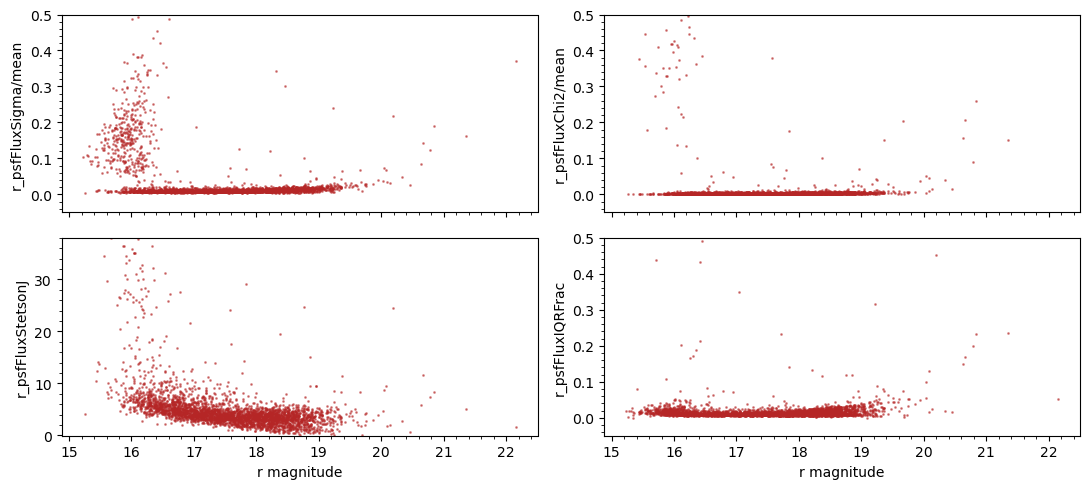

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(11, 5), sharey=False, sharex=True)

ax[0][0].plot(DiaObjsFull['rmag'],
              DiaObjsFull['r_psfFluxSigma']/DiaObjsFull['r_scienceFluxMean'],
              '.', ms=2, alpha=0.5, color=filter_colors['r'])
ax[0][0].set_ylabel('r_psfFluxSigma/mean')
ax[0][0].set_ylim(-0.05, 0.5)
ax[0][0].minorticks_on()

ax[0][1].plot(DiaObjsFull['rmag'],
              DiaObjsFull['r_psfFluxChi2']/DiaObjsFull['r_scienceFluxMean'],
              '.', ms=2, alpha=0.5, color=filter_colors['r'])
ax[0][1].set_ylabel('r_psfFluxChi2/mean')
ax[0][1].set_ylim(-0.05, 0.5)
ax[0][1].minorticks_on()

ax[1][0].plot(DiaObjsFull['rmag'],
              DiaObjsFull['r_psfFluxStetsonJ'],
              '.', ms=2, alpha=0.5, color=filter_colors['r'])
ax[1][0].set_xlabel('r magnitude')
ax[1][0].set_ylabel('r_psfFluxStetsonJ')
ax[1][0].set_ylim(-0.05, 38)
ax[1][0].minorticks_on()

ax[1][1].plot(DiaObjsFull['rmag'],
              DiaObjsFull['r_psfFluxIQRFrac'],
              '.', ms=2, alpha=0.5, color=filter_colors['r'])
ax[1][1].set_xlabel('r magnitude')
ax[1][1].set_ylabel('r_psfFluxIQRFrac')
ax[1][1].set_ylim(-0.05, 0.5)
ax[1][1].minorticks_on()

plt.tight_layout()
plt.show()

> Figure 1: Lightcurve statistics of all candidates from the TAP search as a function of r magnitude. Upper left: `r_psfFluxSigma` vs. magnitude. Upper right: `r_psfFluxChi2` vs. magnitude. Lower left: `r_psfFluxStetsonJ` vs. magnitude. Lower right: `r_psfFluxIQRFrac` (the interquartile range) vs. magnitude.

We see that there is a well-defined locus of points in each panel above, where the majority of objects are tightly grouped. In particular, most objects have `r_psfFluxSigma` (normalized by the mean flux) near zero, implying that they are non-variable. Likewise, the normalized `r_psfFluxChi2` "chi-squared" values are typically near zero for most objects. The `r_psfFluxStetsonJ` variability index is clumped at low values (less than 10) for most objects, and the IQR range is also near zero for most stars. Note that the "clouds" of objects at bright magnitudes (around *r* = 16) are due to saturated stars causing poor measurements.

## 2.3. Filter for variable star candidates

In addition to the `nDiaSources` > 40 and S/N > 5 cuts applied in the TAP query above, filter the `DiaObject` results (defined as `DiaObjsFull`) with the following conditions:

* `nDiaSources` > 40: Candidate has more than 40 `DiaSource` detections (in all bands); applied in TAP query.
* `r_scienceFluxMean` S/N > 5: Candidate has signal-to-noise larger than 5 in the `visit_image`s; applied in TAP query.
* `r_psfFluxSigma` > 0.02: Candidate has flux variations with sigma larger than 2 percent.
* `r_psfFluxIQRFrac` > 0.05: Candidate has IQR flux variations with larger than 5 percent.
* `r_psfFluxStetsonJ` > 10: Candidate has Stetson J index larger than 10.
* 17 < *r* < 21.5: Candidate has mean *r* magnitude between 17 to 21.5 (i.e., faint enough to avoid saturation in any images as the star varies in brightness, while also avoiding faint sources with large measurement uncertainties).
* -0.2 < (*g-r*) < 0.6: Candidate has a *g-r* color within the instability strip (i.e., RR Lyrae or delta Scuti-type variables).

Apply these cuts to the `DiaObjsFull` table, extracting a list of candidates as `pick_all`.

In [10]:
sigcut = 0.02
stetsoncut = 10.0
iqrcut = 0.05

magrange = (DiaObjsFull['rmag'] > 17.0) & (DiaObjsFull['rmag'] < 21.5)
pick_color = ((DiaObjsFull['gmag']-DiaObjsFull['rmag']) < 0.4) &\
             ((DiaObjsFull['gmag']-DiaObjsFull['rmag']) > -0.2)
pick_sig = (DiaObjsFull['r_psfFluxSigma']/DiaObjsFull['r_scienceFluxMean'] > sigcut)
pick_stetsonj = (DiaObjsFull['r_psfFluxStetsonJ'] > stetsoncut)
pick_iqr = (DiaObjsFull['r_psfFluxIQRFrac'] > iqrcut)

pick_all = np.where(magrange & pick_sig & pick_stetsonj & pick_iqr & pick_color)
len(pick_all[0])

4

Plot the statistical distributions again, but this time marking the cuts applied and the `pick_all` sample of candidate variables. Plot them on a log scale to more clearly show differences.

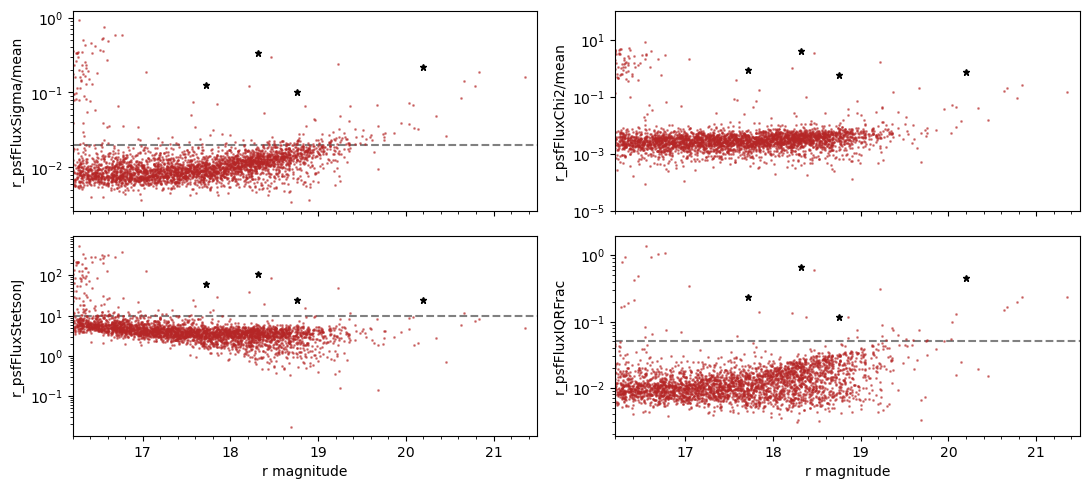

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(11, 5), sharey=False, sharex=True)

ax[0][0].hlines(sigcut, 16.2, 21.5, color='gray', linestyle='--')
ax[0][0].plot(DiaObjsFull['rmag'],
              DiaObjsFull['r_psfFluxSigma']/DiaObjsFull['r_scienceFluxMean'],
              '.', ms=2, alpha=0.5, color=filter_colors['r'])
ax[0][0].plot(DiaObjsFull['rmag'][pick_all],
              DiaObjsFull['r_psfFluxSigma'][pick_all]/DiaObjsFull['r_scienceFluxMean'][pick_all],
              'k*', ms=5)
ax[0][0].set_ylabel('r_psfFluxSigma/mean')
ax[0][0].set_yscale('log')
ax[0][0].set_xlim(16.2, 21.5)
ax[0][0].minorticks_on()

ax[0][1].plot(DiaObjsFull['rmag'],
              DiaObjsFull['r_psfFluxChi2']/DiaObjsFull['r_scienceFluxMean'],
              '.', ms=2, alpha=0.5, color=filter_colors['r'])
ax[0][1].plot(DiaObjsFull['rmag'][pick_all],
              DiaObjsFull['r_psfFluxChi2'][pick_all]/DiaObjsFull['r_scienceFluxMean'][pick_all],
              'k*', ms=5)
ax[0][1].set_ylabel('r_psfFluxChi2/mean')
ax[0][1].set_ylim(1e-5, 1e2)
ax[0][1].set_xlim(16.2, 21.5)
ax[0][1].set_yscale('log')
ax[0][1].minorticks_on()

ax[1][0].hlines(stetsoncut, 16.2, 21.5, color='gray', linestyle='--')
ax[1][0].plot(DiaObjsFull['rmag'], DiaObjsFull['r_psfFluxStetsonJ'],
              '.', ms=2, alpha=0.5, color=filter_colors['r'])
ax[1][0].plot(DiaObjsFull['rmag'][pick_all],
              DiaObjsFull['r_psfFluxStetsonJ'][pick_all],
              'k*', ms=5)
ax[1][0].set_xlabel('r magnitude')
ax[1][0].set_ylabel('r_psfFluxStetsonJ')
ax[1][0].set_xlim(16.2, 21.5)
ax[1][0].set_yscale('log')
ax[1][0].minorticks_on()

ax[1][1].hlines(iqrcut, 16.2, 21.5, color='gray', linestyle='--')
ax[1][1].plot(DiaObjsFull['rmag'], DiaObjsFull['r_psfFluxIQRFrac'],
              '.', ms=2, alpha=0.5, color=filter_colors['r'])
ax[1][1].plot(DiaObjsFull['rmag'][pick_all], DiaObjsFull['r_psfFluxIQRFrac'][pick_all], 'k*', ms=5)
ax[1][1].set_xlabel('r magnitude')
ax[1][1].set_ylabel('r_psfFluxIQRFrac')
ax[1][1].set_xlim(16.2, 21.5)
ax[1][1].set_yscale('log')
ax[1][1].minorticks_on()

plt.tight_layout()
plt.show()

> Figure 2: Panels the same as in Figure 1, but with the selected candidate variables highlighted as black stars, demonstrating that the candidates are all well above the thresholds used for selection.

We see that the candidates are all above the thresholds used for selection. Notice that although we didn't select on "Chi2", all of the candidates nonetheless have high values of this quantity.

## 3. Plot lightcurves of the selected variable star candidates

### 3.1. Plot the raw, as-measured lightcurves

Loop over the selected objects, querying the `ForcedSourceOnDiaObject` table for all measurements of each object, based on the `diaObjectId`. Plot the lightcurve for each.

diaObjectId: 614431011979133047
number of measurements: 133


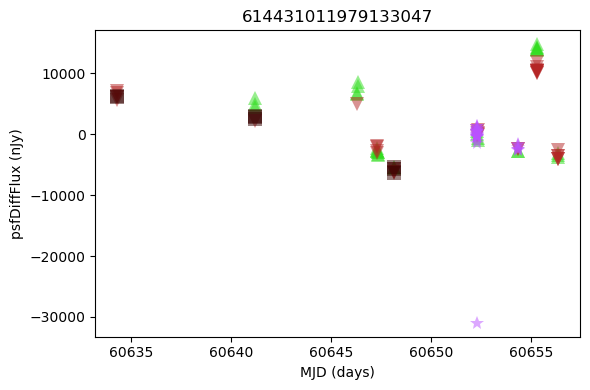

diaObjectId: 614429019114307699
number of measurements: 223


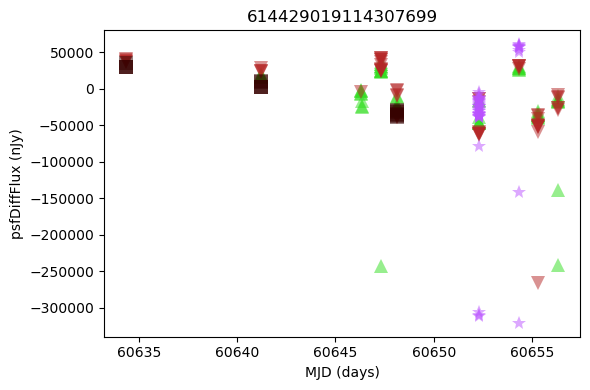

diaObjectId: 614435753623027782
number of measurements: 225


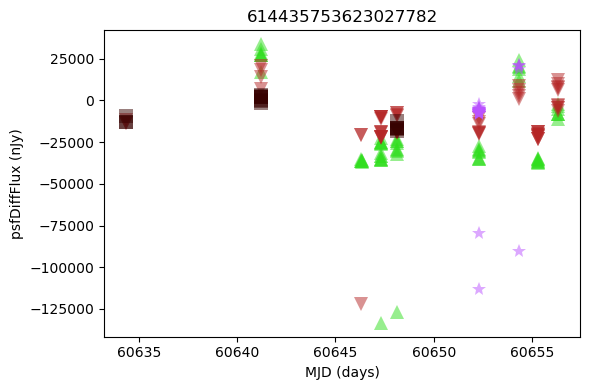

diaObjectId: 614435616184074318
number of measurements: 221


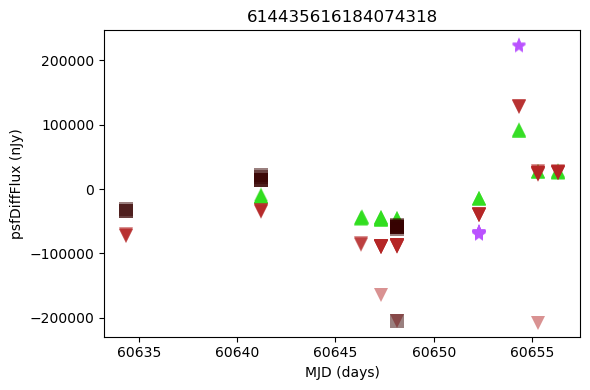

In [12]:
filters = ['g', 'r', 'i', 'z']
ids = DiaObjsFull[pick_all]['diaObjectId']

results_dict = {}

for id in ids:
    print(f"diaObjectId: {id}")

    results = service.search("SELECT fsodo.diaObjectId, "
                             "fsodo.detector, fsodo.visit, fsodo.band, "
                             "fsodo.psfFlux, fsodo.psfFluxErr, "
                             "fsodo.psfDiffFlux, fsodo.psfDiffFluxErr, "
                             "cv.expMidptMJD "
                             "FROM dp1.ForcedSourceOnDiaObject as fsodo "
                             "JOIN dp1.CcdVisit as cv "
                             "ON (cv.visitId = fsodo.visit AND cv.detector = fsodo.detector)"
                             "WHERE diaObjectId = "+str(id))

    results = results.to_table()
    results_dict[id] = results
    print(f"number of measurements: {len(results)}")

    fig = plt.figure(figsize=(6, 4))

    for f, filt in enumerate(filters):
        fx = np.where(results['band'] == filt)[0]
        plt.plot(results['expMidptMJD'][fx], results['psfDiffFlux'][fx],
                 filter_symbols[filt], ms=10, mew=0, alpha=0.5,
                 color=filter_colors[filt])

    plt.title(str(id))
    plt.xlabel('MJD (days)')
    plt.ylabel('psfDiffFlux (nJy)')

    plt.tight_layout()
    plt.show()
    del results

> Figure 3: Lightcurves of all selected candidates. Each panel shows the measured difference-image flux (`psfDiffFlux`) in nanoJanskies vs. observation time in MJD days.

### 3.2. Plot phased lightcurves

The lightcurves above show that these objects clearly vary in brightness, but it is unclear whether there is a pattern (for example a periodic signal) in that variability.

Loop over the candidates, extracting the frequency of the highest peak in the Lomb-Scargle results, and placing each measurement into the correct phase of the star's variability period.

diaObjectId: 614431011979133047
number of measurements: 133
period:  0.40387060 d


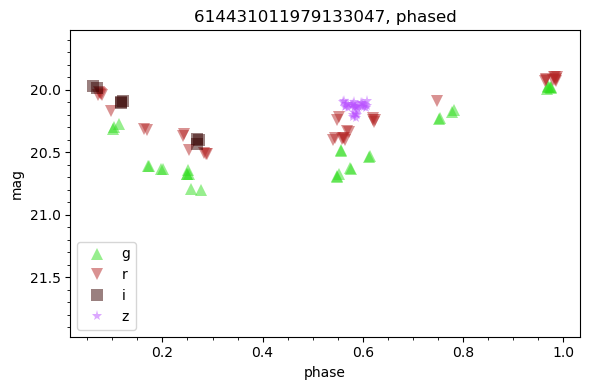



diaObjectId: 614429019114307699
number of measurements: 223
period:  0.07087944 d


/opt/lsst/software/stack/conda/envs/lsst-scipipe-12.1.0/lib/python3.13/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


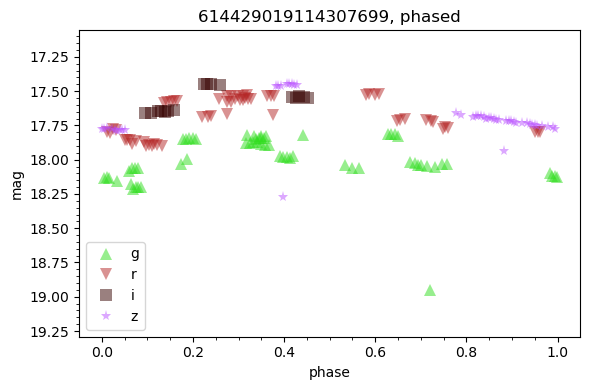



diaObjectId: 614435753623027782
number of measurements: 225
period:  0.07667406 d


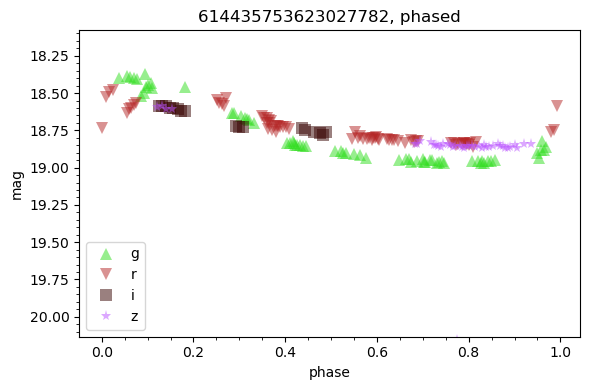



diaObjectId: 614435616184074318
number of measurements: 221
period:  0.29969858 d


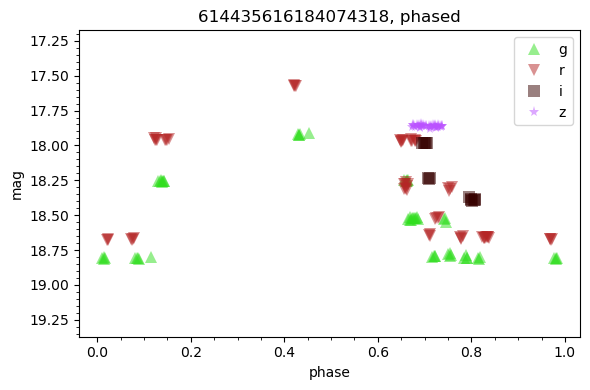

In [13]:
periods = {}

for id in ids:
    print(f"diaObjectId: {id}")

    results = results_dict[id]
    print(f"number of measurements: {len(results)}")

    ############################
    ### Plot a phased lightcurve
    minfreq = 1 / (1.0*u.d)
    maxfreq = 1 / (0.05*u.d)

    obj_mjd_days = np.array(results['expMidptMJD']) * u.day
    obj_fluxes = np.array(results['psfFlux'])
    obj_flux_errs = np.array(results['psfFluxErr'])
    obj_frequency, obj_power =\
        LombScargleMultiband(obj_mjd_days, obj_fluxes,
                             results['band'], obj_flux_errs).autopower(minimum_frequency=minfreq,
                                                                       maximum_frequency=maxfreq,
                                                                       samples_per_peak=20)
    max_power = np.argmax(obj_power)
    obj_freq = obj_frequency[max_power]
    obj_period = 1.0 / obj_freq
    print(f"period: {obj_period: .8F}")
    periods[id] = obj_period

    t0 = 0.0
    obj_mjd_norm = (obj_mjd_days.value - t0) / obj_period.value
    obj_phase = np.mod(obj_mjd_norm, 1.0)

    mag = (obj_fluxes*u.nJy).to(u.ABmag).value

    fig = plt.figure(figsize=(6, 4))

    for f, filt in enumerate(filters):
        fx = np.where(results['band'] == filt)[0]

        plt.plot(obj_phase[fx], mag[fx],
                 filter_symbols[filt], color=filter_colors[filt],
                 ms=8, mew=0, alpha=0.5, label=filt)

    plt.ylim(np.nanpercentile(mag, 95) + 0.4, np.nanpercentile(mag, 5) - 0.4)
    plt.xlabel('phase')
    plt.ylabel('mag')
    plt.title(str(id)+", phased")
    plt.legend()
    plt.minorticks_on()
    plt.tight_layout()
    plt.show()

    print('\n')
    del results

> Figure 4: As in Figure 3, the figure shows lightcurves of all selected candidates. In this plot, vertical axis shows PSF magnitudes from forced measurements on the direct images. The horizontal axis shows phase, which runs from 0 to 1, placing each observed point into the proper phase of the variable's measured period.

### 3.3. Refine the period search

It is clear that the stars above exhibit some periodic variable behavior, but the phased lightcurves still don't look as "clean" as one would like. This is likely because the period estimates are not quite correct. Re-run the Lomb-Scargle algorithm for each star, changing the following two things:

1. Zoom in on a narrower range of periods to search, using the period from our initial estimates to define the new range, and
2. Increase the "samples_per_peak" in the Lomb-Scargle search to more finely sample the distribution of frequencies.

Wrap the steps in a function that can be called for each star.

In [14]:
def period_search(results_dict, my_id, period0, pick_band='r'):
    min_period = period0 - 0.2
    max_period = period0 + 0.2

    if min_period < 0:
        min_period = 0.05

    min_period = min_period * u.day
    max_period = max_period * u.day

    min_freq = 1.0 / max_period
    max_freq = 1.0 / min_period

    # Select the star based on its ID, and measurements in the requested band
    results = results_dict[my_id]
    results_band = results[results['band'] == pick_band]

    # Run Lomb-Scargle and pick the "best" frequency
    obj_mjd_days_band = np.array(results_band['expMidptMJD']) * u.day
    obj_fluxes_band = np.array(results_band['psfFlux'])
    obj_frequency, obj_power =\
        LombScargle(obj_mjd_days_band, obj_fluxes_band).autopower(minimum_frequency=min_freq,
                                                                  maximum_frequency=max_freq,
                                                                  samples_per_peak=2000)

    peakbin = np.argmax(obj_power)
    mean_peak_freq = obj_frequency[peakbin].value

    # Plot the frequency and power from Lomb-Scargle
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))

    plt.sca(ax[0])
    plt.plot(obj_frequency, obj_power)
    plt.vlines(mean_peak_freq, 0, 0.3, linestyle='--', color='red')
    plt.minorticks_on()
    plt.xlabel('frequency (1/d)')
    plt.ylabel('power')

    plt.sca(ax[1])
    plt.plot(1 / obj_frequency, obj_power)
    plt.vlines(1/mean_peak_freq, 0, 0.3, linestyle='--', color='red')
    plt.minorticks_on()
    plt.xlabel('period (d)')
    plt.ylabel('power')

    fig.suptitle(my_id)
    plt.tight_layout()
    plt.show()

    max_power = np.argmax(obj_power)
    obj_freq = obj_frequency[max_power]
    obj_period = 1.0 / obj_freq

    t0 = 0.0
    obj_mjd_days = np.array(results['expMidptMJD']) * u.day
    obj_fluxes = np.array(results['psfFlux'])

    obj_mjd_norm = (obj_mjd_days.value - t0) / obj_period.value
    obj_phase = np.mod(obj_mjd_norm, 1.0)

    mag = (obj_fluxes*u.nJy).to(u.ABmag).value

    # Plot a phased lightcurve
    fig = plt.figure(figsize=(6.5, 3))

    for band in ['g', 'r', 'i', 'z']:
        results_band = (results['band'] == band)

        plt.plot(obj_phase[results_band], mag[results_band],
                 filter_symbols[band], color=filter_colors[band],
                 ms=8, mew=0, alpha=0.5, label=band)

    plt.gca().invert_yaxis()
    plt.legend()
    plt.title(f"{my_id}; period: {obj_period: .8F}")
    plt.xlabel('phase')
    plt.ylabel('magnitude')
    plt.ylim(np.nanpercentile(mag, 95)+0.3, np.nanpercentile(mag, 5)-0.3)
    plt.minorticks_on()
    plt.show()

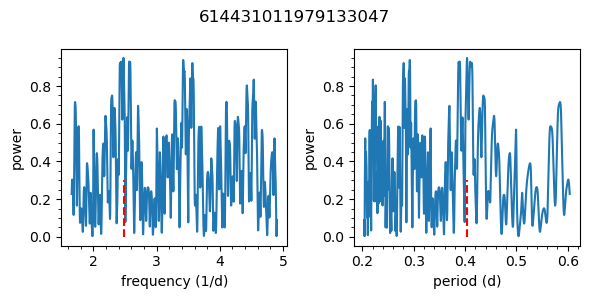

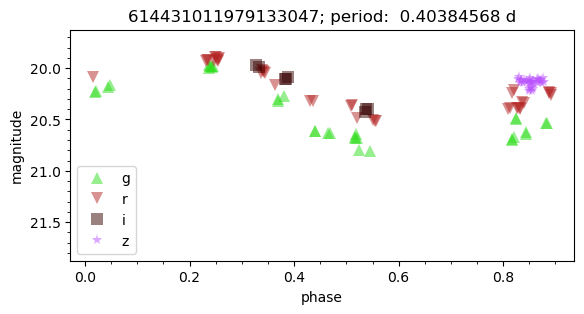

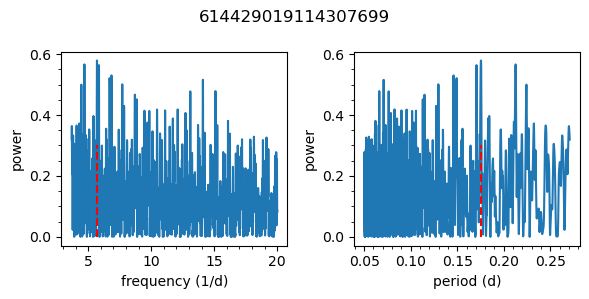

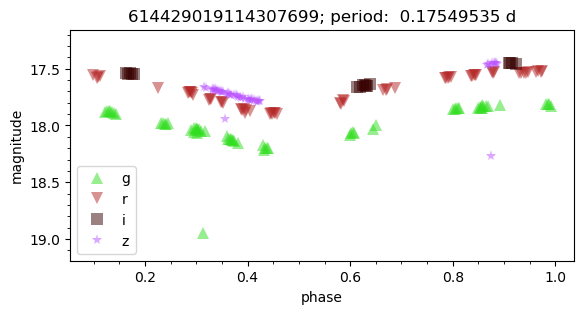

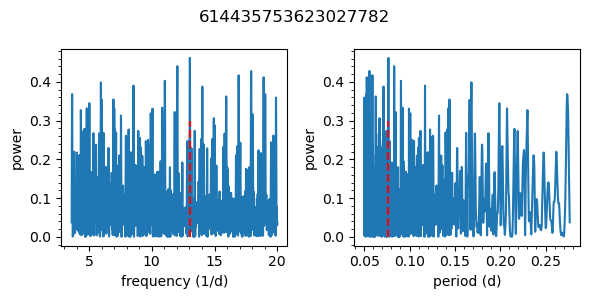

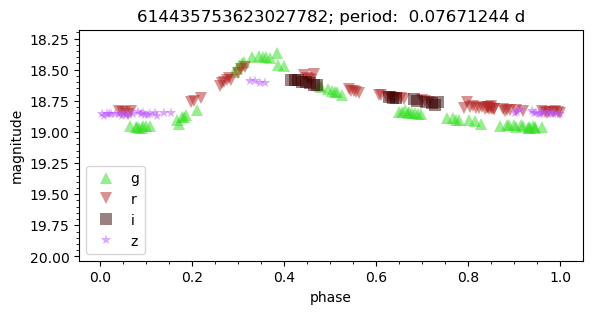

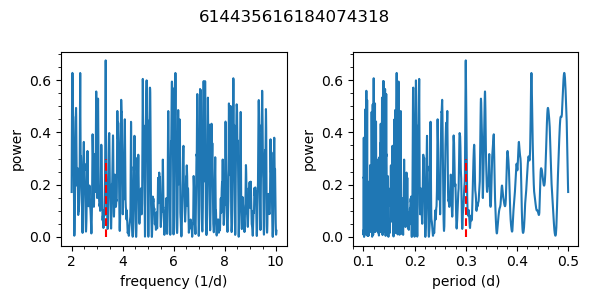

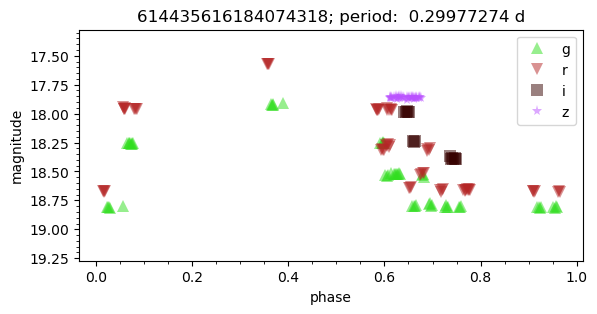

In [15]:
for my_id in ids:
    period_search(results_dict, my_id, periods[my_id].value, pick_band='r')

> Figure 5: As in Figure 4, the lower panel of each figure shows a lightcurve for each selected candidate, in magnitude vs. phase. The upper plot for each candidate shows Lomb-Scargle "power" vs. frequency on the left, and power vs. period on the right. The selected "best" period is marked with a vertical red line in each panel. The lightcurves are phased with this period, and the period is labeled at the top of the lightcurve.

### 3.4. Use Simbad to check whether these objects are known variables

Query Simbad using the ra, dec position of each object to see if they have already been classified as variable objects. Start by compiling the results in a dict, then combine them all into an Astropy table.

In [16]:
simbad = Simbad()
simbad.add_votable_fields("otype", "allfluxes")

simbad_dict = {}

for obj in DiaObjsFull[pick_all]:
    simbad_dict[obj['diaObjectId']] = simbad.query_region(SkyCoord(obj['ra'], obj['dec'],
                                                          unit=(u.deg, u.deg),
                                                          frame='icrs'), radius=2 * u.arcsec)

In [17]:
for i, key in enumerate(simbad_dict.keys()):
    if i == 0:
        tab = simbad_dict[key]
    else:
        tab = vstack([tab, simbad_dict[key]])

In [18]:
tab

main_id,ra,dec,coo_err_maj,coo_err_min,coo_err_angle,coo_wavelength,coo_bibcode,otype,B,F150W,F200W,F444W,g,G,H,i,I,J,K,r,R,u,U,V,z
,deg,deg,mas,mas,deg,,,,,,,,,,,,,,,,,,,,
object,float64,float64,float32,float32,int16,str1,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
Gaia DR3 2912361076526273664,94.79082095637,-24.68114574769,0.2441,0.3775,90,O,2020yCat.1350....0G,RR*,--,--,--,--,--,20.227672576904297,--,--,--,--,--,--,--,--,--,--,--
ATO J094.7208-25.0576,94.72085793586001,-25.057681439002227,0.0555,0.0739,90,O,2020yCat.1350....0G,EB*,--,--,--,--,--,17.629438400268555,16.461999893188477,--,--,16.663000106811523,--,--,--,--,--,--,--
NAME LSST-DP1-O-614435753623041404,94.92262715543416,-25.231841609010836,0.0808,0.1163,90,O,2020yCat.1350....0G,*,--,--,--,--,--,18.65022850036621,--,--,--,--,--,--,--,--,--,--,--
QSO B0618-252,95.13382066007,-25.254857407469995,0.0798,0.0999,90,O,2020yCat.1350....0G,QSO,18.31999969482422,--,--,--,--,18.52629280090332,--,--,--,--,--,--,18.469999313354492,--,--,18.5,--
